In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import nltk
import seaborn as sns
import re
import random
from time import time
from wordcloud import WordCloud
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer
import matplotlib.pyplot as plt
from __future__ import unicode_literals
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

In [2]:
# import nltk
# nltk.download()
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

In [3]:
# import csv
lyrics = pd.read_csv('lyrics.csv')

In [4]:
# drop missing data and songs without genre
lyrics = lyrics.dropna()
lyrics = lyrics[lyrics.genre.str.contains("Not Available") == False]
lyrics = lyrics[lyrics.genre.str.contains("Other") == False]

# keep Rock genre only
lyrics = lyrics[lyrics.genre == 'Rock']

# drop unexistent or artists that don't make sense
lyrics = lyrics[lyrics.artist != 'aeena']
lyrics = lyrics[lyrics.artist != 'adaaeaaineay-iaidiia']
lyrics = lyrics[lyrics.artist != 'girls-generation']
lyrics = lyrics[lyrics.artist != 'edaiaoidee']

In [5]:
lyrics.nunique()

index     108700
song       84762
year          48
artist      3761
genre          1
lyrics    102003
dtype: int64

In [6]:
# lowercase everything
lyrics['lyrics'] = lyrics['lyrics'].str.lower()
lyrics['song'] = lyrics['song'].str.lower()
lyrics['artist'] = lyrics['artist'].str.lower()
 
# attempt to drop foreign language songs
searchfor = [' tu ', ' und ', ' ein ', ' dich ', ' amor ', ' ich ', ' auf ', ' bin ', ' dich ', ' du ', ' nicht ', ' el ']
lyrics = lyrics[~lyrics.lyrics.str.contains('|'.join(searchfor))]

In [7]:
# only keep artists with at least 100 songs
lyrics = lyrics.groupby("artist").filter(lambda x: len(x) > 99)

# take a sample of 100 songs from each artist
grouped = lyrics.groupby('artist')
lyrics = grouped.apply(lambda x: x.sample(n=100))

In [8]:
lyrics.nunique()

index     23500
song      21251
year         47
artist      235
genre         1
lyrics    22245
dtype: int64

In [9]:
'''# take a sample of 100 artist
artist_list = lyrics.artist.unique()
artist_list = artist_list[random.sample(range(235), 100)]

# make sure the number of artists is correct
len(artist_list)''';

In [10]:
'''# apply our 100 artist sample to our dataframe
lyrics = lyrics[lyrics['artist'].isin(artist_list)]''';

In [11]:
# combine song name and lyrics
lyrics['lyrics'] = lyrics['lyrics'] + lyrics['song']

# remove all apotrophes
lyrics['lyrics'] = lyrics['lyrics'].str.replace("'", "")

In [12]:
lyrics_original = lyrics
lyrics.head()

index                                    song  year artist  \
artist                                                                       
10-cc  238134  238134                      don-t-turn-me-away  2006  10-cc   
       238115  238115                         clockwork-creep  2006  10-cc   
       238183  238183  the-second-sitting-for-the-last-supper  2008  10-cc   
       238074  238074                           for-your-love  2009  10-cc   
       238113  238113                               life-line  2006  10-cc   

              genre                                             lyrics  
artist                                                                  
10-cc  238134  Rock  you and i dont have to hurry\ntake your time n...  
       238115  Rock  "im a clockwork creep\nand i cant get to sleep...  
       238183  Rock  another fish head in the dustbin\nanother lose...  
       238074  Rock  for your love\nfor your love\nid give you ever...  
       238113  Rock  ten thousand miles away from someone\nten thou...

In [13]:
# combine all lyrics for each artist
lyrics = lyrics.groupby('artist').lyrics.apply(lambda x: x.sum())

c:\users\todd\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 'artist' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  


In [14]:
# clean some text
def text_clean(text):
    text = text.replace("\n"," ").replace(","," ").replace("in' ",'ing ').replace("i've","i have").replace("'cos","bacause").replace("'s", " is")
    text = text.replace("'re" ," are").replace(",","").replace("'d"," would").replace("n't"," not").replace("i'm","i am").replace("dont","do not")
    text = text.replace("'ll"," will").replace("!"," ").replace("-"," ").replace('"',"").replace(")","").replace("(","").replace("'","")
    text = text.replace("[","").replace("]","").replace("?","").replace(" x ","").replace("%","").replace("#","").replace("ya","yes").replace("darlin","darling")
    text = text.replace("0","").replace("1","").replace("2","").replace("3","").replace("4","").replace("5","").replace("6","").replace("7","").replace("8","").replace("9","")
    return text

lyrics = text_clean(lyrics)

lyrics = lyrics.str.replace('in ', 'ing ')
lyrics = lyrics.str.replace(' ing ', 'in')

In [15]:
# set stemmer
stemmer = SnowballStemmer('english')

# define a function that accepts text and returns a list of lemmas or stems
def word_tokenize(text, how='lemma'):
    words = TextBlob(text).words
    if how == 'lemma':
        return [word.lemmatize(pos='v') for word in words]
    elif how == 'stem':
        return [stemmer.stem(word) for word in words]
    
# create and fit our vectorizer
tfidf = TfidfVectorizer(max_df=0.5, # drop words that occur in more than 1/2 of texts
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, # convert everything to lower case
                             norm=u'l2', # longer paragraphs and shorter paragraphs treated equally
                             smooth_idf=True, # add 1 to all document frequencies
                             max_features=125, # limit to top 100 words
                             analyzer=lambda x:word_tokenize(x, how='lemma')
                        )
vect = tfidf.fit_transform(lyrics)

In [16]:
# preserve column names
vocab = tfidf.vocabulary_
tfidf = tfidf.transform(lyrics)

# be sure keys are sorted
tfidf = pd.DataFrame(tfidf.toarray(), columns=sorted(vocab.keys()))

In [17]:
# see our result
tfidf.head()

,2,action,american,anybody,anywhere,asleep,ass,b,ba,bang,...,weight,whenever,whoa,wire,wo,wonderful,x2,yea,yo,york
0,0.000000,0.062219,0.244912,0.000000,0.000000,0.000000,0.104344,0.000000,0.000000,0.036505,...,0.000000,0.000000,0.000000,0.014842,0.0,0.081661,0.000000,0.149749,0.000000,0.00000
1,0.020207,0.029990,0.000000,0.000000,0.009254,0.009347,0.156471,0.107404,0.052561,0.082113,...,0.009687,0.029519,0.280293,0.009539,0.0,0.000000,0.069606,0.036090,0.302105,0.02999
2,0.000000,0.015459,0.026079,0.000000,0.000000,0.000000,0.008642,0.000000,0.000000,0.018140,...,0.000000,0.000000,0.032108,0.177014,0.0,0.008116,0.030755,0.000000,0.000000,0.00000
3,0.000000,0.170326,0.047890,0.041051,0.000000,0.000000,0.000000,0.000000,0.000000,0.049967,...,0.000000,0.041913,0.000000,0.040631,0.0,0.000000,0.000000,0.000000,0.000000,0.00000
4,0.000000,0.426505,0.000000,0.000000,0.035891,0.000000,0.000000,0.000000,0.000000,0.045498,...,0.000000,0.000000,0.000000,0.036997,0.0,0.040711,0.000000,0.139980,0.000000,0.00000


In [18]:
'''# create extra feature, length
length = (lyrics_original.groupby('artist')['lyrics']
                            .apply(lambda x: np.mean(x.str.len()))
                            .reset_index(name='mean_len_text'))
tfidf = tfidf.join(length)''';

In [19]:
# remove columns that have two characters or less
remove = tfidf.columns.str.findall('\w{3,}').str.join(' ')
remove = pd.DataFrame(remove, columns =['columns'])
remove = remove[remove['columns'] != '']
tfidf = tfidf[remove['columns']]

In [20]:
pd.set_option('display.max_rows', 500)
tfidf.nunique()

action          103
american         82
anybody         110
anywhere        118
asleep          116
ass              83
bang             75
battle          110
beach           113
beer             96
bitch            83
bomb            107
bow             112
breeze          116
brown           116
business         96
bye              89
christmas       117
cmon             70
comfort         112
company         110
cos              84
cruel           118
doctor          107
doo              31
downinthe        97
drum            105
dumb             85
ease            116
endless         118
everythings     116
fallinlove       88
fame             95
flesh           105
food            105
fuck            114
garden          113
gim              69
gods            105
grey            110
heavens         103
hed             118
huh              64
hurry           116
instrumental    104
inthe           114
jack            103
jam              86
joe              64
john             91


In [21]:
# drop nonsense columns
tfidf.drop(columns = ['doo', 'gim', 'inthe', 'jack', 'joe', 'john', 'johnny', 'mary' 'kimi', 'pum', 'theyd', 'therell', 'whoa', 'yea', 'x2'], inplace=True, errors='ignore')

# fix names
tfidf = tfidf.rename(columns = {'mountaing':'mountain'})
tfidf = tfidf.rename(columns = {'york':'new york'})
tfidf = tfidf.rename(columns = {'nothings':'nothing'})

In [22]:
# store for cluster
cluster = tfidf

# Each batch will be made up of 200 data points.
minibatchkmeans = MiniBatchKMeans(
    init='random',
    n_clusters=3,
    batch_size=200)
minibatchkmeans.fit(cluster)

# Add the new predicted cluster memberships to the data frame.
predict_mini = minibatchkmeans.predict(cluster)

# join our cluster number to each row/artist
predict_mini = pd.DataFrame(predict_mini, columns=['cluster'])
tfidf = tfidf.join(predict_mini)

In [23]:
# check how different clusters are
tfidf.groupby('cluster').mean()

,action,american,anybody,anywhere,asleep,ass,bang,battle,beach,beer,...,sunday,surrender,underneath,vision,weep,weight,whenever,wire,wonderful,new york
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.032074,0.031664,0.031456,0.032966,0.025921,0.013022,0.032998,0.033396,0.030119,0.026628,...,0.030178,0.038670,0.030456,0.028788,0.032654,0.026740,0.034598,0.028161,0.043799,0.029336
1,0.029540,0.036277,0.023511,0.035779,0.032573,0.067398,0.031676,0.023608,0.016653,0.038739,...,0.023767,0.023017,0.027801,0.044348,0.016258,0.045985,0.020560,0.017395,0.011849,0.024228
2,0.004448,0.062265,0.083474,0.034159,0.054523,0.011135,0.000000,0.067979,0.018730,0.005208,...,0.013590,0.051371,0.100418,0.063807,0.017063,0.092900,0.019000,0.067040,0.016553,0.034705


In [24]:
# make an artist column
tfidf['artist'] = lyrics.index

In [25]:
# create lists of artist from each cluster
one_list = tfidf.artist[tfidf.cluster == 0]
two_list = tfidf.artist[tfidf.cluster == 1]
three_list = tfidf.artist[tfidf.cluster == 2]
four_list = tfidf.artist[tfidf.cluster == 3]
five_list = tfidf.artist[tfidf.cluster == 4]

In [26]:
# create dataframes for each cluster
cluster_one = tfidf[tfidf['artist'].isin(one_list)]
cluster_two = tfidf[tfidf['artist'].isin(two_list)]
cluster_three = tfidf[tfidf['artist'].isin(three_list)]
cluster_four = tfidf[tfidf['artist'].isin(four_list)]
cluster_five = tfidf[tfidf['artist'].isin(five_list)]

In [27]:
# drop cluster number and artist name
cluster_one_totals = cluster_one.drop(columns=['cluster', 'artist'])
cluster_two_totals = cluster_two.drop(columns=['cluster', 'artist'])
cluster_three_totals = cluster_three.drop(columns=['cluster', 'artist'])
cluster_four_totals = cluster_four.drop(columns=['cluster', 'artist'])
cluster_five_totals = cluster_five.drop(columns=['cluster', 'artist'])

In [28]:
# add together the results for each cluster
cluster_one_totals = cluster_one_totals.sum()
cluster_two_totals = cluster_two_totals.sum()
cluster_three_totals = cluster_three_totals.sum()
cluster_four_totals = cluster_four_totals.sum()
cluster_five_totals = cluster_five_totals.sum()

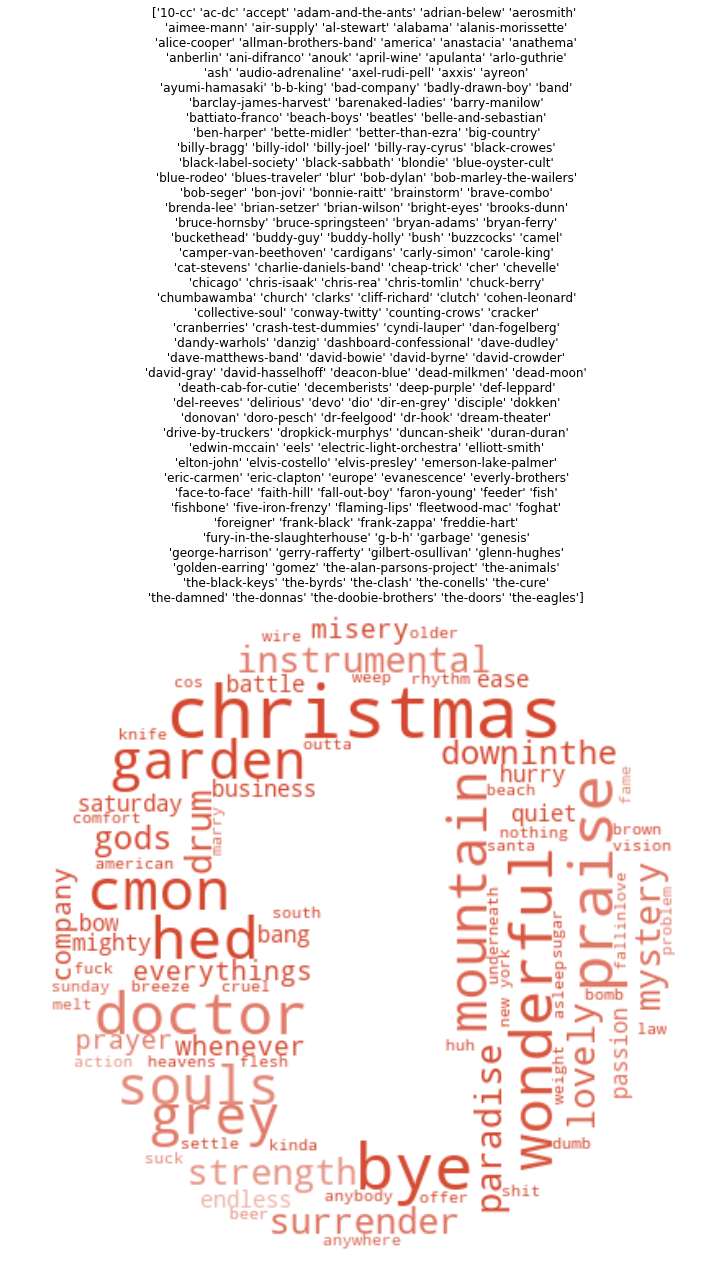

<Figure size 432x288 with 0 Axes>

In [29]:
# create word cloud for cluster one
d = path.dirname('__file__')
mask = np.array(Image.open(path.join(d, "one.png")))
image_colors = ImageColorGenerator(mask)

wordcloud_one = WordCloud().fit_words(cluster_one_totals)

first = WordCloud(background_color="white", width=800, height=800, max_words=80, 
                  mask=mask, max_font_size=120, random_state=50).fit_words(cluster_one_totals)

plt.figure(figsize=(12,12))
plt.title(one_list.unique(), fontsize=12)
plt.imshow(first.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.figure()
plt.show()

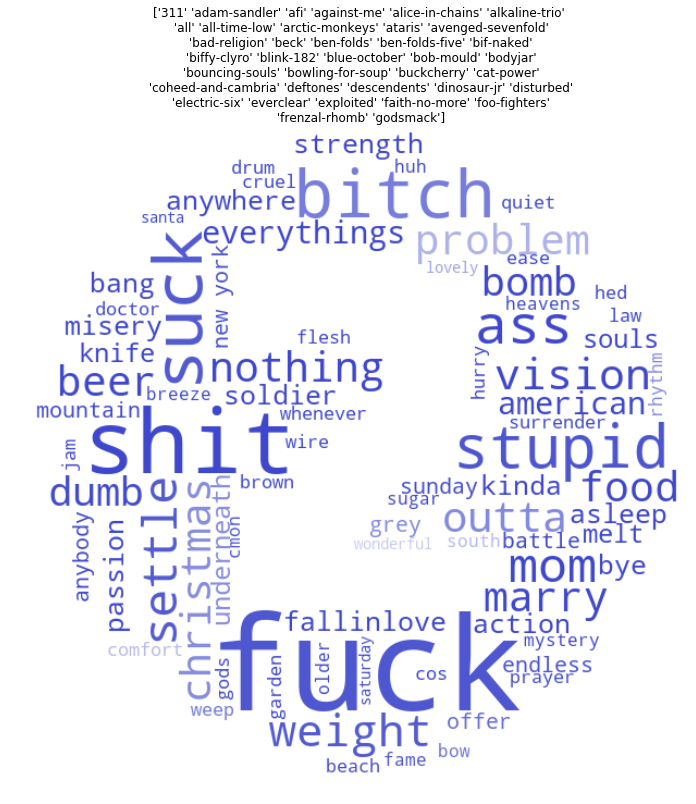

<Figure size 432x288 with 0 Axes>

In [30]:
# create word cloud for cluster two
mask = np.array(Image.open(path.join(d, "two.png")))
image_colors = ImageColorGenerator(mask)

wordcloud_two = WordCloud().fit_words(cluster_two_totals)

second = WordCloud(background_color="white", width=800, height=800, max_words=80, 
                  mask=mask, max_font_size=120, random_state=50).fit_words(cluster_two_totals)

plt.figure(figsize=(12,12))
plt.title(two_list.unique(), fontsize=12)
plt.imshow(second.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.figure()
plt.show()

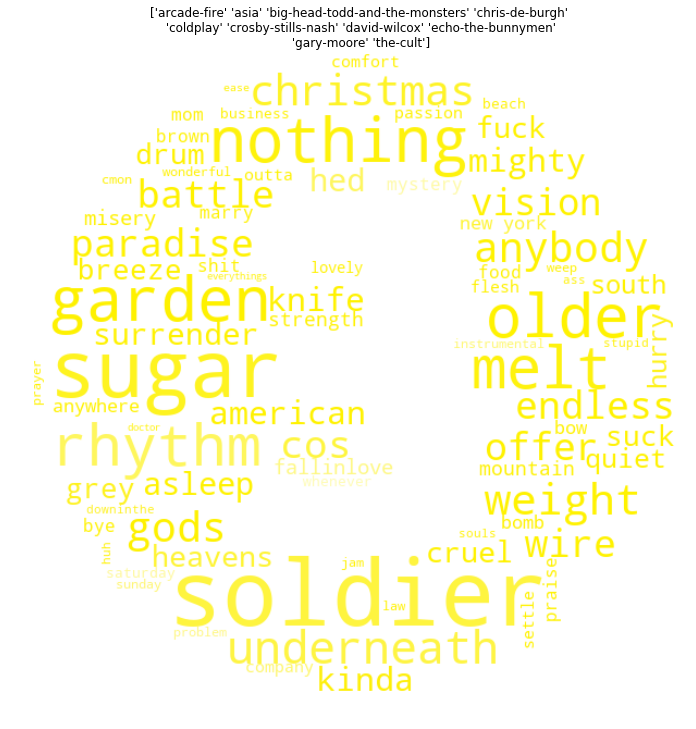

<Figure size 432x288 with 0 Axes>

In [31]:
# create word cloud for cluster three
mask = np.array(Image.open(path.join(d, "three.png")))
image_colors = ImageColorGenerator(mask)

wordcloud_three = WordCloud().fit_words(cluster_three_totals)

third = WordCloud(background_color="white", width=800, height=800, max_words=80, 
                  mask=mask, max_font_size=120, random_state=50).fit_words(cluster_three_totals)

plt.figure(figsize=(12,12))
plt.title(three_list.unique(), fontsize=12)
plt.imshow(third.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.figure()
plt.show()